# Натянуть сову на линейное пространство

Создайте эмбеддинги слов и визуализируйте векторные операции над ними: сложение, вычитание, взятие ближайшего, дальнейшего и прочее. Сравните качество представлений gensim и BERT с точки зрения операций над словами, докажите примерами.

Для создания эмбеддингов с gensim обучите модель на нормализованных текстовых данных. Данные найдите на kaggle или выберите один из предложенных датасетов. Для создания эмбеддингов с BERT используйте предобученные модели.

Предлагаемые датасеты:
 - [sentiment твитов про ковид](https://www.kaggle.com/datatattle/covid-19-nlp-text-classification)
 - [Amazon product reviews](https://www.kaggle.com/kashnitsky/hierarchical-text-classification)
 - [Отзывы интернет-магазина](https://www.kaggle.com/shymammoth/shopee-reviews)
 - [Тексты статей конференции NIPS](https://www.kaggle.com/rowhitswami/nips-papers-1987-2019-updated?select=papers.csv)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
from tqdm.notebook import tqdm, trange

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cpu


In [2]:
data = pd.read_csv('data/corona.csv')

In [3]:
txt_data = data.OriginalTweet.to_frame()

txt_data.info()
txt_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
dtypes: object(1)
memory usage: 321.7+ KB


,OriginalTweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1,advice Talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...
3,My food stock is not the only one which is emp...
4,"Me, ready to go at supermarket during the #COV..."


In [4]:
from typing import List, Tuple
from collections import Counter
from itertools import chain
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

nltk.data.path.append('./data')
nltk.download('stopwords', download_dir = './data')
eng_stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to ./data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from gensim.parsing.preprocessing import *

def build_vocab(texts: List[List[str]]) -> Counter:
    words = list(chain.from_iterable(texts))
    vocab = Counter(words)
    return vocab

custom_filters = [lambda x: x.lower(),
                  lambda x: re.sub(r'http\S+', '', x),
                  strip_tags,
                  strip_non_alphanum,
                  strip_punctuation,
                  strip_multiple_whitespaces,
                  strip_numeric,
                  lambda x: remove_stopwords(x, stopwords = eng_stopwords),
                  
                  stem_text]

def preprocess(text: str) -> np.ndarray:
    return preprocess_string(text, filters = custom_filters)

texts = txt_data.OriginalTweet.apply(preprocess)
vocab = build_vocab(texts)

In [6]:
print(len(vocab))
print(vocab.most_common(10))

print(len(texts))
texts.head()

42042
[('covid', 22185), ('coronaviru', 18215), ('price', 9139), ('store', 8315), ('supermarket', 7821), ('food', 7348), ('groceri', 6787), ('peopl', 5652), ('consum', 5393), ('amp', 5197)]
41157


0                     [menyrbi, phil, gahan, chrisitv]
1    [advic, talk, neighbour, famili, exchang, phon...
2    [coronaviru, australia, woolworth, give, elder...
3    [food, stock, on, empti, pleas, panic, enough,...
4    [readi, go, supermarket, covid, outbreak, para...
Name: OriginalTweet, dtype: object

In [7]:
from gensim.models import Word2Vec

# gs = Word2Vec(sentences = texts,
#               vector_size = 256,
#               seed = 0,
#               min_count = 1,
#               workers = 8,
#               sg = False,
#               epochs = 10
#              )

gs = Word2Vec.load("data/models/gs_mod.model")

print(gs.wv.vectors.shape)

(42042, 256)


In [8]:
import umap

points = umap.UMAP(random_state = 0, n_jobs = 8).fit_transform(gs.wv.vectors[:500])

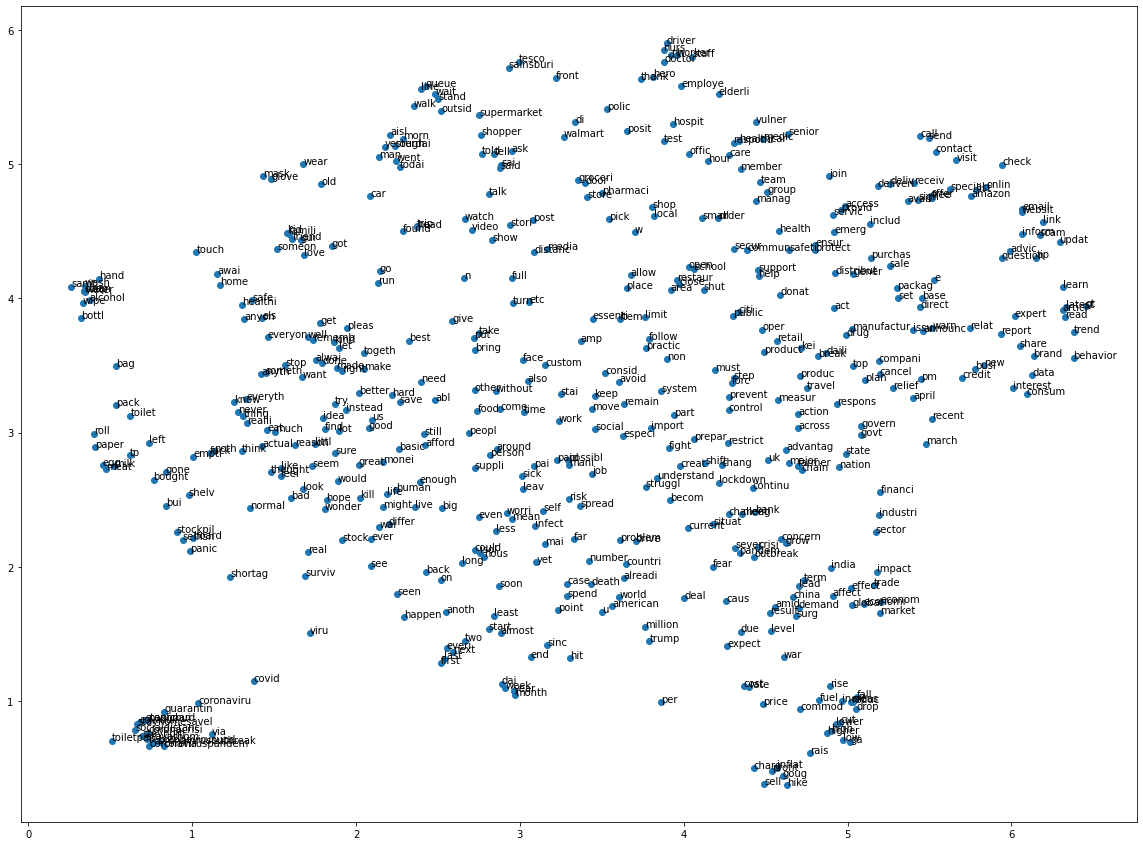

In [9]:
fig, ax = plt.subplots(figsize=(20, 15))
ax.scatter(points[:, 0], points[:, 1])

for i, txt in enumerate(gs.wv.index_to_key[:500]):
    ax.annotate(txt, (points[i, 0], points[i, 1]))

In [10]:
import torch
from transformers import BertTokenizerFast, BertModel

bert = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # возращать эмбеддинги каждого слова
                                  )
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

bert.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [11]:
@torch.no_grad()
def make_sentence_embedding_bert(text: str) -> torch.Tensor:
    tokens_tensor, _, segments_tensors = tokenizer(text, return_tensors = 'pt').values()
    
    # calc embeddings
    outputs = bert(tokens_tensor, segments_tensors)
    last_layer_embs = outputs.last_hidden_state
    sentense_embedding = last_layer_embs.squeeze(0).sum(dim=0)
    
    return sentense_embedding

In [12]:
texts = texts.astype(str)
embs_bert = []

In [13]:
# for text in tqdm(vocab):
#     emb = make_sentence_embedding_bert(text)
#     embs_bert.append(emb)

In [14]:
# to_save = np.stack([ten.detach().numpy() for ten in embs_bert])
# np.save("data/models/bert2", to_save)
# gs.save("data/models/gs_mod.model")
embs_bert = np.load("data/models/bert2.npy")
# gs = Word2Vec.load("data/models/gs_mod.model")


In [15]:
# np.save("data/models/vocab2", list(vocab.keys()))
# fixed_vocab = list(vocab.keys())
fixed_vocab = np.load("data/models/vocab2.npy")

In [16]:
print(gs.wv.vectors.shape)
print(embs_bert.shape)

(42042, 256)
(42042, 768)


In [17]:
ten_bert = torch.from_numpy(embs_bert)
ten_gs = torch.from_numpy(gs.wv.vectors)

In [18]:
print(ten_bert.size())
print(ten_gs.size())

torch.Size([42042, 768])
torch.Size([42042, 256])


In [44]:
def bert_sum(query: str) -> List[float]:
    return sum([make_sentence_embedding_bert(word) for word in query.split()])

def best_gs(query: str) -> List[Tuple[str, float]]:
    try:
        return gs.wv.most_similar(positive = preprocess(query))
    except KeyError:
        return [("None", 0)] * 10

def best_bert(query: str) -> List[Tuple[str, float]]:
    q_emb = make_sentence_embedding_bert(query)
    similarities = torch.nn.functional.cosine_similarity(q_emb, ten_bert, dim = -1)
    temp = list(zip(fixed_vocab, similarities.detach().numpy()))
    temp.sort(key = lambda tup: tup[1], reverse = True)
    return temp[:10]

def best_bert_sum(query: str) -> pd.DataFrame:
    q_emb = bert_sum(query)
    similarities = torch.nn.functional.cosine_similarity(q_emb, ten_bert, dim = -1)
    temp = list(zip(fixed_vocab, similarities.detach().numpy()))
    temp.sort(key = lambda tup: tup[1], reverse = True)
    return pd.DataFrame(temp[:10], columns = ['bert_word', 'bert_sim'])

def bests(query: str) -> pd.DataFrame:
    gsdf = pd.DataFrame(best_gs(query), columns = ['gs_word', 'gs_sim'])
    bertdf = pd.DataFrame(best_bert(query), columns = ['bert_word', 'bert_sim'])
    return pd.concat([gsdf, bertdf], axis = 1)

def worst_gs(query: str) -> List[Tuple[str, float]]:
    try:
        return gs.wv.most_similar(negative = preprocess(query))
    except KeyError:
        return [("None", 0)] * 10

def worst_bert(query: str) -> List[Tuple[str, float]]:
    q_emb = make_sentence_embedding_bert(query)
    similarities = torch.nn.functional.cosine_similarity(q_emb, ten_bert, dim = -1)
    temp = list(zip(fixed_vocab, similarities.detach().numpy()))
    temp.sort(key = lambda tup: tup[1])
    return temp[:10]

def worsts(query: str) -> pd.DataFrame:
    gsdf = pd.DataFrame(worst_gs(query), columns = ['gs_word', 'gs_sim'])
    bertdf = pd.DataFrame(worst_bert(query), columns = ['bert_word', 'bert_sim'])
    return pd.concat([gsdf, bertdf], axis = 1)

In [42]:
from IPython.display import display

print('covid: ')
display(bests('covid'))
print('death: ')
display(bests('death'))
print('cure: ')
display(bests('cure'))

covid: 


,gs_word,gs_sim,bert_word,bert_sim
0,coronaviru,0.629557,covid,1.000000
1,joshbreslowwkrn,0.625815,covidtr,0.895813
2,timmartin,0.585853,provid,0.895654
3,viru,0.585742,convid,0.888659
4,syop,0.556140,covidnz,0.887932
5,corona,0.552678,corvid,0.884095
6,novel,0.550481,divid,0.878962
7,autosal,0.528213,covidpr,0.873739
8,diseas,0.527729,covidtest,0.873738
9,sunwaypyramid,0.527620,covidkind,0.863785


death: 


,gs_word,gs_sim,bert_word,bert_sim
0,case,0.753204,death,1.000000
1,begin,0.702509,fate,0.926077
2,fatal,0.675536,oblivion,0.914377
3,hubai,0.674904,isolation,0.906348
4,contract,0.663967,metal,0.896717
5,sediti,0.661152,satan,0.896656
6,tokhang,0.650495,shadow,0.895717
7,began,0.643736,casket,0.894712
8,threat,0.641282,wine,0.893802
9,korea,0.639032,ruin,0.893434


cure: 


,gs_word,gs_sim,bert_word,bert_sim
0,vaccin,0.895676,cure,1.000000
1,treatment,0.855846,blackout,0.954481
2,forzayid,0.795677,melt,0.953652
3,norahodonnel,0.790270,marrow,0.953605
4,fake,0.783285,deliver,0.953451
5,bogu,0.761616,facial,0.951274
6,vaxxer,0.757569,vortex,0.950108
7,blackmarketear,0.749595,fusion,0.949558
8,fals,0.734404,flavor,0.949317
9,claim,0.726186,filter,0.948395


In [21]:
print("schizophrenia: ")
display(bests('schizophrenia'))

schizophrenia: 


,gs_word,gs_sim,bert_word,bert_sim
0,None,0,asthma,0.928386
1,None,0,leukemia,0.919980
2,None,0,amnesia,0.900298
3,None,0,rape,0.898794
4,None,0,psycho,0.896179
5,None,0,socio,0.895062
6,None,0,intellect,0.892556
7,None,0,theft,0.891307
8,None,0,pneumonia,0.890827
9,None,0,despair,0.890382


In [28]:
q1 = "covid vaccine"
q2 = "vaccine covid"
display(bests(q1))
display(bests(q2))

,gs_word,gs_sim,bert_word,bert_sim
0,cure,0.769350,covidb,0.826511
1,treatment,0.746511,covidcam,0.822864
2,norahodonnel,0.741108,covidkind,0.811042
3,prototyp,0.721641,covidgr,0.808603
4,admiss,0.697077,coviddc,0.805504
5,fraudul,0.691316,covidbc,0.800863
6,wearer,0.676804,coronaviruswatch,0.798191
7,bogu,0.675493,covidpr,0.796292
8,forzayid,0.669574,coronavirusdc,0.796160
9,fip,0.667621,covidtest,0.795389


,gs_word,gs_sim,bert_word,bert_sim
0,cure,0.769350,coronavirusvaccin,0.823190
1,treatment,0.746511,coronaviruscur,0.818673
2,norahodonnel,0.741108,coronavirusscam,0.809101
3,prototyp,0.721641,covidcam,0.806373
4,admiss,0.697077,coronaviruspa,0.805654
5,fraudul,0.691316,antivir,0.803583
6,wearer,0.676804,covidma,0.802271
7,bogu,0.675493,influenzavaccin,0.800734
8,forzayid,0.669574,coronavirusinsa,0.799366
9,fip,0.667621,coronavirusact,0.799176


In [45]:
display(best_bert_sum(q1))
display(best_bert_sum(q2))

,bert_word,bert_sim
0,covid,0.953386
1,burgess,0.899536
2,acronym,0.896703
3,corona,0.896355
4,musica,0.894940
5,provid,0.894025
6,cod,0.893064
7,resin,0.891609
8,silicon,0.891282
9,cardiac,0.890880


,bert_word,bert_sim
0,covid,0.953386
1,burgess,0.899536
2,acronym,0.896703
3,corona,0.896355
4,musica,0.894940
5,provid,0.894025
6,cod,0.893064
7,resin,0.891609
8,silicon,0.891282
9,cardiac,0.890880


In [24]:
cgs = gs.wv.get_vector('covid')
dgs = gs.wv.get_vector('death')
display(pd.DataFrame(gs.wv.similar_by_vector(cgs - dgs), columns = ['gs_word', 'gs_sim']))
display(pd.DataFrame(gs.wv.similar_by_vector(dgs - cgs), columns = ['gs_word', 'gs_sim']))


,gs_word,gs_sim
0,covid,0.593502
1,shamibrahim,0.491011
2,smallbiztip,0.484067
3,posnat,0.476075
4,unoffici,0.470907
5,mahfwork,0.458437
6,disasterblast,0.432025
7,myusshop,0.431324
8,futureofwork,0.429706
9,xml,0.428103


,gs_word,gs_sim
0,death,0.620064
1,case,0.593675
2,eighti,0.521276
3,record,0.460459
4,foschinigroup,0.454053
5,eabl,0.434950
6,takeyourselfhom,0.431198
7,hubai,0.423236
8,pbm,0.421888
9,taiwan,0.419970


In [25]:
cbert = make_sentence_embedding_bert('covid')
dbert = make_sentence_embedding_bert('death')

similarities = torch.nn.functional.cosine_similarity(cbert - dbert, ten_bert, dim = -1)
temp = list(zip(fixed_vocab, similarities.detach().numpy()))
temp.sort(key = lambda tup: tup[1])
v1 = temp[:10]

similarities = torch.nn.functional.cosine_similarity(dbert - cbert, ten_bert, dim = -1)
temp = list(zip(fixed_vocab, similarities.detach().numpy()))
temp.sort(key = lambda tup: tup[1])
v2 = temp[:10]

display(pd.DataFrame(v1, columns = ['bert_word', 'bert_sim']))
display(pd.DataFrame(v2, columns = ['bert_word', 'bert_sim']))

,bert_word,bert_sim
0,death,0.040818
1,middlesbrough,0.072311
2,cinema,0.076983
3,portsmouth,0.079355
4,deathbeforebean,0.086239
5,endow,0.090302
6,refuge,0.090751
7,naaaahhhhhh,0.091171
8,anyhow,0.091249
9,stage,0.095543


,bert_word,bert_sim
0,covid,-0.726089
1,covidtr,-0.697506
2,covidnz,-0.658346
3,covidtest,-0.656273
4,corvid,-0.654585
5,covidpr,-0.647170
6,covidlk,-0.637980
7,covidd,-0.633344
8,covidfr,-0.622061
9,convid,-0.618156


# Projector

Из прошлого задания вы выяснили наиболее хорошую для представления связей между словами модель. Спроецируйте ~2-3 тысячи наиболее популярных слов из выбранного корпуса в tensorflow projector.

In [26]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

In [27]:
embs = np.stack(embs_bert[:2000])
writer.add_embedding(embs,
                     metadata = fixed_vocab[:2000])
writer.close()